In [1]:
import pandas as pd
import seaborn as sns
import MySQLdb
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
user = os.getenv('DSA_DBPROD_USER')
password = os.getenv('DSA_DBPROD_PASS')
host = os.getenv('DSA_DBPROD_HOST')
db = os.getenv('DSA_DBPROD_DBNAME')

conn = 'mysql://%s:%s@%s:3306/%s' % (user, password, host, db)

In [6]:
meetings_attended = r"""
    select member_id, count(*) as generals_attended
    from attendees
    join (select *
          from meetings
          where name like '%%General Meeting%%') as m
    on attendees.meeting_id = m.id
    group by member_id;
"""
meetings_attended_df = pd.read_sql(meetings_attended, conn)

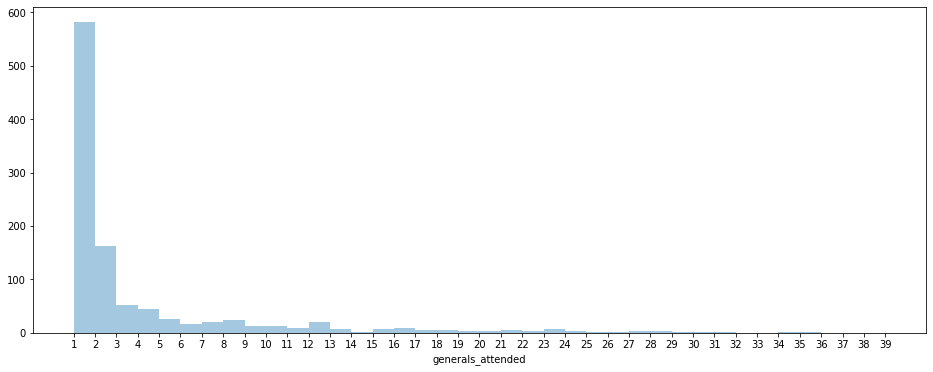

In [7]:
plt.figure(figsize=(16, 6))
ax = sns.distplot(meetings_attended_df['generals_attended'], bins=range(1,40), kde=False)
ax.set_xticks(range(1,40))

In [47]:
first_year_stickyness = """
    select a.member_id, count(*) as generals_attended
    from (select member_id, min(start_time) as date
        from attendees a
        join meetings m on a.meeting_id = m.id
        where m.name like '%%General Meeting%%'
        group by a.member_id) as first_meeting
    join attendees a on a.member_id=first_meeting.member_id
    join meetings m2 on a.meeting_id = m2.id
    where datediff(m2.start_time, first_meeting.date) <= 364 and m2.name like '%%General Meeting%%'
    group by a.member_id;
"""
first_year_stickyness_df = pd.read_sql(first_year_stickyness, conn)

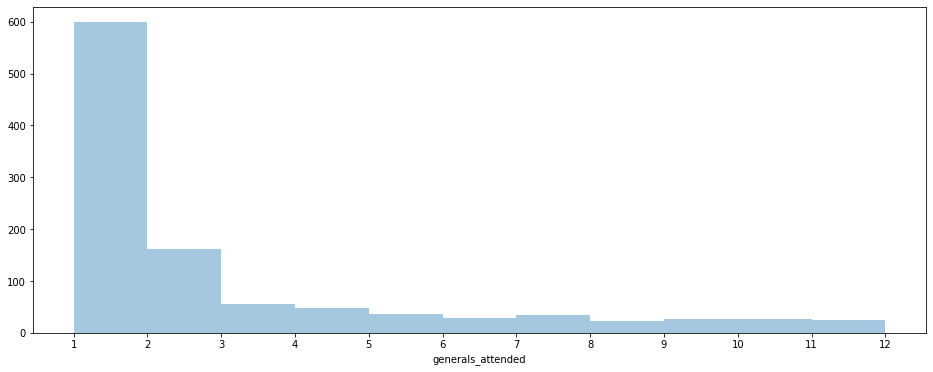

In [61]:
plt.figure(figsize=(16, 6))
ax = sns.distplot(first_year_stickyness_df['generals_attended'], bins=range(1, 13), kde=False)
ax.set_xticks(range(1,13))

In [77]:
unique_members_q = """
    select count(*) as count
    from members;
"""
unique_general_attendees_q = """
    select count(*) as count
    from members
    where id in (select member_id
        from attendees a
        join meetings m on a.meeting_id = m.id
        where m.name like '%%General Meeting%%'
        group by a.member_id);
"""
unique_intro_attendees_q = """
    select count(distinct  members.id) as count
    from members
    where id in (select member_id
        from attendees a
        join meetings m on a.meeting_id = m.id
        where m.name like '%%Intro to DSA%%' or m.name like '%%New Members Meeting%%');
"""
unique_members = pd.read_sql(unique_members_q, conn)['count'][0]
unique_general_attendees = pd.read_sql(unique_general_attendees_q, conn)['count'][0]
unique_intro_attendees = pd.read_sql(unique_intro_attendees_q, conn)['count'][0]

In [78]:
print("Unique Members: %s, Unique General Attendees: %s, General Attendance Rate: %s" % (unique_members, unique_general_attendees, unique_general_attendees / unique_members))
print("Unique Members: %s, Unique Intro Attendees: %s, Intro Attendance Rate: %s" % (unique_members, unique_intro_attendees, unique_intro_attendees / unique_members))


Unique Members: 2438, Unique General Attendees: 1063, General Attendance Rate: 0.4360131255127153
Unique Members: 2438, Unique Intro Attendees: 454, Intro Attendance Rate: 0.18621821164889255


In [116]:
member_attendance_q = """
    select fc.id,
       case
        when fc.created < fc.joined and fc.created < fc.first_meeting then fc.created
        when fc.joined < fc.first_meeting then fc.joined
        else fc.first_meeting
       end as first_contact,
       a.meeting_id,
       m2.start_time
    from (select m.id, min(m.date_created) as created, min(mu.join_date) as joined, min(me.start_time) as first_meeting
        from members m
        left outer join memberships_usa mu on m.id = mu.member_id
        join attendees a on m.id = a.member_id
        join meetings me on a.meeting_id = me.id
        group by m.id) as fc
    join attendees a on a.member_id=fc.id
    join (select *
          from meetings m2
          where m2.name like '%%General Meeting%%') as m2
        on a.meeting_id = m2.id;
"""
member_attendance = pd.read_sql(member_attendance_q, conn).set_index('id')

In [120]:
member_attendance

first_contact  meeting_id          start_time
id                                                      
1    2007-01-10 00:00:00           1 2017-05-30 13:30:00
1    2007-01-10 00:00:00           3 2017-06-20 01:30:00
1    2007-01-10 00:00:00           4 2017-07-20 01:00:00
1    2007-01-10 00:00:00          12 2017-12-21 02:30:00
2    2016-11-13 00:00:00           1 2017-05-30 13:30:00
...                  ...         ...                 ...
3642 2020-01-23 02:00:00          69 2020-01-23 02:00:00
3647 2020-02-27 02:00:00          71 2020-02-27 02:00:00
3658 2020-02-05 18:48:40          71 2020-02-27 02:00:00
3682 2020-02-12 06:00:00          71 2020-02-27 02:00:00
3696 2020-02-12 06:00:00          71 2020-02-27 02:00:00

[4016 rows x 3 columns]

In [123]:
def nmonth_unbounded_retention(starting_month, num_months, members):
    months = range(num_months)
    retained = []
    for month in months:
        current_month = starting_month + pd.DateOffset(months=month)
        
        active = members[(members['first_contact'].dt.floor('d') - pd.offsets.MonthBegin(1) <= current_month)]
        member_count = len(active.index.unique())
        attendees = active[active['start_time'].dt.floor('d') - pd.offsets.MonthBegin(1) == current_month]
        attendee_count = len(attendees.index.unique())
        
        retained.append((member_count, attendee_count))
    return retained

In [124]:
nmonth_unbounded_retention(pd.Timestamp(2017, 4, 1), 36, member_attendance)

[(169, 55),
 (200, 85),
 (217, 78),
 (270, 119),
 (336, 144),
 (372, 105),
 (398, 105),
 (421, 100),
 (441, 84),
 (461, 84),
 (494, 124),
 (523, 117),
 (532, 91),
 (545, 102),
 (608, 155),
 (658, 151),
 (695, 137),
 (723, 116),
 (750, 121),
 (769, 120),
 (794, 117),
 (831, 154),
 (855, 131),
 (883, 155),
 (901, 110),
 (922, 159),
 (949, 131),
 (965, 122),
 (980, 111),
 (995, 130),
 (1008, 97),
 (1034, 111),
 (1044, 82),
 (1059, 126),
 (1063, 87),
 (1063, 0)]